<div style="text-align: right"> __ Provided on May 27 and due on June 17__ [BRI516, Spring/2019] </div>

For homework in general:
* Install `Anaconda` and create an environment with `NumPy`, `Pandas`, `Matplotlib`, `scikit-learn` in Python 3.5 
* Please upload your jupyter-notebook file for homework to `Blackboard`
* Please visualize the results as much as possible and discuss your results at least one line of text

In [1]:
## Disable warning message
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
## import library & module
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import os
import sys
import struct
import numpy as np

#### [Hw05] Implementing a Multilayer Neural Networks using TensorFlow (TF) 1.x (Ch. 13)


##### (1) Data preparation
    (1a) Load the train dataset and test dataset of the MNIST 
    

  

In [3]:
## import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets("./data/mnist/", validation_size=5000)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


    (1b) Set the first 55,000 samples in the training dataset as training data, the remaining 5,000 samples in the training dataset as validation data, and 10,000 samples in the test dataset as test data.

In [4]:
## Set the first 55,000 samples in the training dataset as training data
X_train = mnist_data.train.images
y_train = mnist_data.train.labels
print('training data\n rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

# the remaining 5,000 samples in the training dataset as validation data
X_valid = mnist_data.validation.images
y_valid = mnist_data.validation.labels
print('validation data\n rows: %d, columns: %d' % (X_valid.shape[0], X_valid.shape[1]))

# 10,000 samples in the test dataset as test data
X_test = mnist_data.test.images
y_test = mnist_data.test.labels
print('test data\n rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

training data
 rows: 55000, columns: 784
validation data
 rows: 5000, columns: 784
test data
 rows: 10000, columns: 784


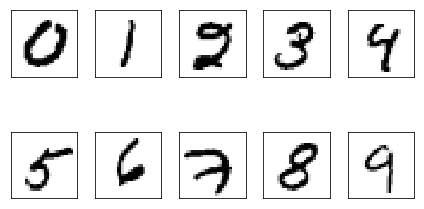

In [5]:
# check
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
## mean centering and normalization:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test, X_valid

print(X_train_centered.shape, y_train.shape)
print(X_valid_centered.shape, y_valid.shape)
print(X_test_centered.shape, y_test.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)
(10000, 784) (10000,)


##### (2) Multilayer perceptron (MLP) using the low-level API of TF (e.g., p. 429)
    (2a) Implement the multilayer perceptron (MLP) with two hidden layers for classification, and evaluate performance in the following scenarios

        (2a-1) for a few choices of hidden nodes per hidden layer

In [7]:
def create_batch_generator(X, y, batch_size=1, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [8]:
## 미리 코드상에는 2a), 2b) 2c) 구현 다 해놓은 후 각각을 값을 줘서 실행할 수 있는 코드로 설정
class MLP(object):    
    def __init__(self, n_features, epochs=10, learning_rate=0.001, l2= 0, n_hidden=32, batch_size=1, shuffle=False, random_seed=None, activation_fn='sigmoid'):
        np.random.seed(random_seed)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.shuffle = shuffle
        self.n_hidden = n_hidden
        self.n_features = n_features
        self.valid_acc_ = 0.0
        self.train_loss_ = 0.0
        self.output_ = 0.0
        self.l2 = l2
        self.batch_size = batch_size
        if activation_fn == 'sigmod':
            self.activation = tf.nn.sigmoid
        elif activation_fn == 'tanh':
            self.activation = tf.nn.tanh
        elif activation_fn == 'relu':
            self.activation = tf.nn.relu
        else: # default
            self.activation = tf.nn.sigmoid
            
        self.test=0.
                
        g = tf.Graph()
        with g.as_default():
            ## set random-seed:
            tf.set_random_seed(random_seed)
            
            ## build the network:
            self.build()
            
            ## initializer
            self.init_op = tf.global_variables_initializer()
            
        ## create a session
        self.sess = tf.Session(graph=g)
    
    def build(self):
        n_classes = 10
        
        ## Placeholders for X and y:
        tf_x = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name='tf_x')
        tf_y = tf.placeholder(dtype=tf.int32, shape=None, name='tf_y')
        
        ## One-hot encoding:
        y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
        
        ## Store layers weight & bias
        weights = {
        'h1': tf.Variable(tf.random_normal([self.n_features, self.n_hidden])),
        'h2': tf.Variable(tf.random_normal([self.n_hidden, self.n_hidden])),
        'out': tf.Variable(tf.random_normal([self.n_hidden, n_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([self.n_hidden])),
            'b2': tf.Variable(tf.random_normal([self.n_hidden])),
            'out': tf.Variable(tf.random_normal([n_classes]))
        }
            
        ## 1st layer(Hidden#1)
        layer_1 = self.activation(tf.add(tf.matmul(tf_x, weights['h1']), biases['b1']))
        
        ## 2nd layer(Hidden#2)
        layer_2 = self.activation(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        
        ## output
        logits = tf.matmul(layer_2, weights['out']) + biases['out']
        self.output_ = logits
        
        ## Prediction
        predictions = {
            #'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),
            'probabilities' : tf.nn.softmax(logits, name='softmax_tensor'),
            'labels' : tf.cast(tf.argmax(logits, axis=1), tf.int32, name='labels')
        }
        
        ## Loss Function and Optimization
        regularizer = (self.l2 / 2) * (tf.reduce_mean(tf.square(weights['h1'])) + tf.reduce_mean(tf.square(weights['h2'])))
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_onehot),name='cross_entropy_loss')
        cross_entropy_loss_l2 = tf.add(cross_entropy_loss, regularizer, name='cross_entropy_loss_l2')
        
        ## Optimizer:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss_l2, name='train_op')
        
        ## Finding accuracy
        correct_predictions = tf.equal(predictions['labels'], tf_y, name='correct_preds')
        
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
        
    def train(self, training_set, validation_set=None, initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)
        
        self.train_cost_ = []
        X_data = np.array(training_set[0])
        y_data = np.array(training_set[1])
        
        if self.batch_size > 1:
            self.shuffle = True
                
        for epoch in range(1, self.epochs + 1):
            batch_gen = create_batch_generator(X_train_centered, y_train, batch_size=self.batch_size, shuffle=self.shuffle)
            
            avg_loss = 0.0
            for i, (batch_x,batch_y) in enumerate(batch_gen):
                feed = {'tf_x:0': batch_x, 'tf_y:0': batch_y}
                loss, _ = self.sess.run(['cross_entropy_loss:0', 'train_op'], feed_dict=feed)
                avg_loss += loss
                
            self.train_loss_ = avg_loss
            print('Epoch %02d: Training Avg. Loss: ' '%7.3f' % (epoch, avg_loss), end=' ')
            
            if validation_set is not None:
                feed = {'tf_x:0': validation_set[0], 'tf_y:0': validation_set[1]}
                valid_acc = self.sess.run('accuracy:0', feed_dict=feed)
                self.valid_acc_ = valid_acc
                print('Validation Acc: %7.3f' % self.valid_acc_)
            else:
                self.valid_acc_ = 0.0
                print()
                
        def predict(self, X_test, return_proba = False):
            feed = {'tf_x:0': X_test}
            if return_proba:
                return self.sess.run('probabilities:0', feed_dict=feed)
            else:
                return self.sess.run('labels:0', feed_dict=feed)

In [9]:
## global varaibles : n_features
n_features = X_train_centered.shape[1]
n_epochs = 1

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

======== hidden size : 32 ========
Epoch 01: Training Avg. Loss: 101016.524 Validation Acc:   0.571
======== hidden size : 64 ========
Epoch 01: Training Avg. Loss: 93909.073 Validation Acc:   0.665
======== hidden size : 128 ========
Epoch 01: Training Avg. Loss: 117630.346 Validation Acc:   0.707
======== hidden size : 256 ========
Epoch 01: Training Avg. Loss: 137716.969 Validation Acc:   0.728
======== hidden size : 512 ========
Epoch 01: Training Avg. Loss: 162072.002 Validation Acc:   0.784
======== hidden size : 1024 ========
Epoch 01: Training Avg. Loss: 205268.536 Validation Acc:   0.808

** best hidden node : 1024


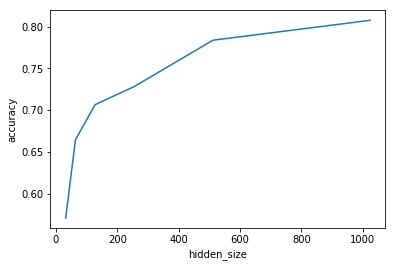

In [10]:
## a few choices of hidden nodes per hidden layer
hidden_nodes = [32, 64, 128, 256, 512, 1024]
val_accs_0 = []
for n_hidden in hidden_nodes:
    mlp = MLP(n_hidden=n_hidden, n_features=n_features, random_seed=123, epochs=n_epochs)
    
    print('======== hidden size : %d ========' % n_hidden)
    mlp.train(training_set=(X_train_centered, y_train), validation_set=(X_valid_centered, y_valid))
    
    val_accs_0.append(mlp.valid_acc_)
    
max_index = val_accs_0.index(max(val_accs_0))
best_hidden = hidden_nodes[max_index]
print('\n** best hidden node : %d' % best_hidden)

        (2a-2) for a few choices of activation functions (i.e., sigmoid, tanh, and ReLU)

In [ ]:
## a few choices of activation functions
activations = ['sigmoid', 'tanh', 'relu']
val_accs_1 = []
for activation_fn in activations:
    mlp_act = MLP(n_hidden=best_hidden, activation_fn=activation_fn, random_seed=123, epochs=n_epochs, n_features=n_features)
    
    print('======== activation function : %s ========' % activation_fn)
    mlp_act.train(training_set=(X_train_centered, y_train), validation_set=(X_valid_centered, y_valid))
    
    val_accs_1.append(mlp_act.valid_acc_)
    
max_index = val_accs_1.index(max(val_accs_1))
best_activation = activations[max_index]
print('\n** best activation function : %s' % best_activation)

======== activation function : sigmoid ========
Epoch 01: Training Avg. Loss: 205268.536 Validation Acc:   0.808
======== activation function : tanh ========
Epoch 01: Training Avg. Loss: 427974.795 Validation Acc:   0.832
======== activation function : relu ========


      (2b) Add the L2-norm regularization of weights to (2a) and evalute performance for a few choices of L2-norm regularization parameters. For this, please pick the best-performing model from (2a)

In [ ]:
## a few choices of L2-norm regularization parameters
l2_weight_decays = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
val_accs_2 = []
for l2_weight_decay in l2_weight_decays:
    mlp_l2 = MLP(n_hidden=best_hidden, activation_fn=best_activation, l2=l2_weight_decay, epochs=n_epochs, n_features=n_features, random_seed=123)
    
    print('======== L2-norm regularization of weights : %f ========' % l2_weight_decay)
    mlp_l2.train(training_set=(X_train_centered, y_train), validation_set=(X_valid_centered, y_valid))
    
    val_accs_2.append(mlp_l2.valid_acc_)
    
max_index = val_accs_2.index(max(val_accs_2))
best_weight = l2_weight_decays[max_index]
print('\n** best L2-norm regularization of weights: %f' % best_weight)

    (2c) Evaluate the performance of (2b) for a few options of mini-batch sizes 

In [ ]:
## a few options of mini-batch sizes
batch_sizes = [4, 8, 16, 32, 64, 128]
val_accs_3 = []
for n_batch_size in batch_sizes:
    mlp_batch = MLP(n_hidden=best_hidden, activation_fn=best_activation, l2=l2_weight_decay, batch_size=n_batch_size, epochs=n_epochs, n_features=n_features, random_seed=123)
    
    print('======== mini-batch sizes : %d ========' % n_batch_size)
    mlp_batch.train(training_set=(X_train_centered, y_train), validation_set=(X_valid_centered, y_valid))
    
    val_accs_3.append(mlp_batch.valid_acc_)
    
max_index = val_accs_3.index(max(val_accs_3))
best_batch = batch_sizes[max_index]
print('\n** best mini-batch sizes: %d' % best_batch)

    (2d) Commonly for the results for (2a) - (2c), discuss the results such as by presenting convergence curves of cost and/or accuracy and by exemplifying the misclassified digits

In [ ]:
def plot_misclassified(X, y, misclassified, predicted):
    fig = plt.figure('misclassified digits', figsize=(10, 10))    
    for i in range(10):
        subplot = fig.add_subplot(2, 5, i+1)            
        subplot.set_xticks([])
        subplot.set_yticks([])            
        subplot.set_title('ground truth : %d\npredicted : %d' % (y[misclassified[i]], predicted[misclassified[i]]))            
        subplot.imshow(X[misclassified[i], :].reshape((28, 28)), cmap=plt.cm.gray_r)

In [ ]:
## a few choices of hidden nodes per hidden layer
plt.plot(hidden_nodes, val_accs_0, label='acc per hidden nodes')
plt.xlabel('hidden_size')
plt.ylabel('accuracy')
plt.show()

preds0 = mlp.predict(X_test_centered)
print('Test Accuracy(hidden nodes): %.2f%%' % (100*np.sum(y_test == preds0)/len(y_test)))

misclassified = np.where(preds0 != y_test)[0]
plot_misclassified(X_test_centered, y_test, misclassified, predicted)

In [ ]:
## a few choices of activation functions
plt.plot([0, 1, 2], val_accs_1, label='acc per activation functions')
plt.xlabel('activation functions (0:sigmoid, 1:tanh, 2:relu)')
plt.ylabel('accuracy')
plt.show()

preds1 = mlp_act.predict(X_test_centered)
print('Test Accuracy(hidden nodes+activation): %.2f%%' % (100*np.sum(y_test == preds1)/len(y_test)))

In [ ]:
## a few choices of L2-norm regularization parameters
plt.plot(l2_weight_decays, val_accs_2, label='acc per L2-norm regularization weight')
plt.xlabel('L2-norm regularization weight')
plt.ylabel('accuracy')
plt.show()

preds2 = mlp_l2.predict(X_test_centered)
print('Test Accuracy(hidden nodes+activation+L2-norm): %.2f%%' % (100*np.sum(y_test == preds2)/len(y_test)))

In [ ]:
## a few options of mini-batch sizes
plt.plot(batch_sizes, val_accs_3, label='acc per mini-batch sizes')
plt.xlabel('mini-batch sizes')
plt.ylabel('accuracy')
plt.show()

preds3 = mlp_batch.predict(X_test_centered)
print('Test Accuracy(hidden nodes+activation+L2-norm+mini-batch): %.2f%%' % (100*np.sum(y_test == preds3)/len(y_test)))